<a href="https://colab.research.google.com/github/fabiocarrara/mbd-dlmra/blob/main/ol3_binary_and_metric_indexing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLMRA OpenLab \#3
-------------------

# Basic Tools for Fast Similarity Search

We will:

*   index binary vectors using the FAISS Library;
*   index arbitrary metric objects with MI-File.


In this (#3) and in the following (#4) OpenLabs, we will explore Approximate Nearest Neighbor (ANN) search solutions for the following three scenarios:

1.  indexing real-valued vectors (e.g., objects $\in \mathbb{R}^n$, distance 
$\in \{L_p, \cos\}$)
2.  indexing binary vectors (e.g., objects $\in \{0,1\}^n$, distance = Hamming)
3.  indexing metric objects (e.g., objects $\in$ Strings, distance = Levenshtein/Edit)

In this notebook (OpenLab #3), we will see the last two scenarios (binary vectors and metric objects), while the first scenario (real-valued vectors), that is the most common one, will be explored in more depth in the next session (OpenLab #4).

## Indexing Binary Vectors ($d =$ Hamming)

Binary vectors are vectors in which each dimension has a binary value.
The most used distance function to compare two binary vectors is the _Hamming distance_ that counts the number of different bits between two binary sequences.

### Getting Started

There are [several libraries](https://github.com/erikbern/ann-benchmarks/) for ANN.
We are going to use the [FAISS](https://github.com/facebookresearch/faiss/wiki) (Facebook AI Similarity Search), a ANN library for real-valued and binary data
that can also exploit GPU acceleration.
Let's install the CPU version.

In [ ]:
!pip install -q faiss-cpu

     |████████████████████████████████| 8.4MB 26.5MB/s 


In [ ]:
!pip install -q ipython-autotime
%load_ext autotime

time: 188 µs (started: 2021-06-01 14:01:00 +00:00)


In [ ]:
import itertools
import time

import faiss
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm

First, let's see how a binary vector looks like. Binary vectors are often packed in bytes (np.uint8) holding 8 bits each.

In [ ]:
binary_vector = np.array([3, 0, 1], dtype=np.uint8)
np.unpackbits(binary_vector)

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1], dtype=uint8)

time: 6.45 ms (started: 2021-05-27 12:24:42 +00:00)


Let's construct an artificial dataset of binary vectors that we will use for our indices.

In [ ]:
d_bits = 256
xb = np.random.randint(0, 256, (1_000_000, d_bits // 8), dtype=np.uint8)
qb = np.random.randint(0, 256, (50, d_bits // 8), dtype=np.uint8)

time: 73 ms (started: 2021-05-27 12:24:42 +00:00)


Next, we will define a helper function for computing a performance metric for indices -- the **recall**, that is the fraction of true neighbors of a query that have been retrieved by the system

$ \text{Recall} = \dfrac{|\text{True Neighbors} \cap \text{Retrieved Objects}|}{|\text{True Neighbors}|}\,.$

In [ ]:
def compute_recall(true_neighbors, predicted_neighbors):
  """ Computes the mean Recall over multiple queries.

  Args:
    - true_neighbors: QxK matrix of object IDs representing the K nearest neighbors for each of the Q queries.
    - predicted_neighbors: QxK matrix of object IDs representing the K retrieved objects for each of the Q queries.
  """
  recalls = []
  for t, p in zip(true_neighbors, predicted_neighbors):
    intersection = np.intersect1d(t, p)
    recall = len(intersection) / len(t)
    recalls.append(recall)

  return np.mean(recalls)

time: 4.78 ms (started: 2021-06-01 14:16:06 +00:00)


### Sequential Search / Bruteforce (NumPy)

First, let's implement the sequential search of binary vectors in NumPy as baseline.

In [ ]:
k = 100

I, D = [], []
for qi in tqdm(qb):
  hammings = np.unpackbits(np.bitwise_xor(qi, xb), axis=1).sum(axis=1)
  rankings = hammings.argsort()
  topk = rankings[:k]
  topk_scores = hammings[topk]

  I.append(topk)
  D.append(topk_scores)

I = np.stack(I)
D = np.stack(D)

D, I

(array([[86, 88, 91, ..., 98, 98, 98],
        [90, 90, 92, ..., 98, 98, 98],
        [88, 88, 90, ..., 98, 98, 98],
        ...,
        [88, 89, 90, ..., 98, 98, 98],
        [90, 92, 92, ..., 98, 98, 98],
        [91, 91, 92, ..., 98, 98, 98]], dtype=uint64),
 array([[581807, 349545, 556368, ..., 950119, 987978, 651536],
        [541216, 819386, 782765, ..., 248453, 946011, 285424],
        [576538, 522254, 489549, ..., 531970, 644255, 100669],
        ...,
        [ 99464, 844374, 317304, ..., 127489, 332216, 577492],
        [823842, 804451, 129053, ..., 415527, 210930, 595551],
        [476971, 892979, 983682, ..., 468407, 962128, 283941]]))

time: 22.2 s (started: 2021-05-27 12:24:42 +00:00)


We will use these results as groundtruth for computing the recall of subsequent solutions.

In [ ]:
true_neighbors = I

time: 1.71 ms (started: 2021-05-27 12:25:04 +00:00)


### Sequential Search / Bruteforce (FAISS)

An equivalent (but more efficient) implementation of a sequential search is provided by FAISS with the _IndexBinaryFlat_ class.

In [ ]:
index = faiss.IndexBinaryFlat(d_bits)
index.add(xb)

time: 17.3 ms (started: 2021-05-27 12:25:04 +00:00)


In [ ]:
D, I = index.search(qb, k)
D, I

(array([[86, 88, 91, ..., 98, 98, 98],
        [90, 90, 92, ..., 98, 98, 98],
        [88, 88, 90, ..., 98, 98, 98],
        ...,
        [88, 89, 90, ..., 98, 98, 98],
        [90, 92, 92, ..., 98, 98, 98],
        [91, 91, 92, ..., 98, 98, 98]], dtype=int32),
 array([[581807, 349545, 556368, ..., 308242,  47114, 647546],
        [541216, 819386, 879002, ..., 389958, 248453, 552829],
        [522254, 576538, 489549, ..., 644780, 644255,  41777],
        ...,
        [ 99464, 844374, 317304, ..., 107390, 235567, 164724],
        [823842, 804451, 129053, ..., 704966, 415527, 428226],
        [892979, 476971, 508690, ..., 640871, 198601, 365105]]))

time: 727 ms (started: 2021-05-27 12:25:04 +00:00)


In [ ]:
compute_recall(true_neighbors, I)

0.9251999999999999

time: 9.95 ms (started: 2021-05-27 12:25:05 +00:00)


### LSH with a single $g()$ (FAISS)

The first index for binary data we will see is the LSH index.
The _IndexBinaryHash_ uses the first `n_bits` bits of the binary vector as hash to split the dataset into buckets.

**NOTE**: FAISS leaves to the user to reorder bits such that the wanted hash is in the first positions of the binary vectors.

In [ ]:
index = faiss.IndexBinaryHash(d_bits, 8)
index.add(xb)

time: 69.9 ms (started: 2021-05-27 12:25:05 +00:00)


At query time, we visit buckets having hashes that are at most `nflip` bits away from the hash of the query.

**NOTE**: `nflip` can be changed at query time without rebuilding the index.

In [ ]:
index.nflip = 4
D, I = index.search(qb, k)

time: 486 ms (started: 2021-05-27 12:25:05 +00:00)


In [ ]:
D, I

(array([[98, 98, 97, ..., 96, 94, 95],
        [98, 98, 98, ..., 90, 96, 95],
        [98, 98, 98, ..., 96, 96, 97],
        ...,
        [99, 99, 98, ..., 97, 95, 98],
        [99, 99, 98, ..., 90, 95, 93],
        [99, 98, 98, ..., 95, 96, 95]], dtype=int32),
 array([[584616,  47114, 616125, ..., 459310, 356290, 876305],
        [552829, 421705, 150872, ..., 541216,  38326, 242156],
        [531970, 406795, 570771, ..., 744716, 337108, 667928],
        ...,
        [ 26637, 796984, 424514, ..., 761377, 797446, 617939],
        [974189, 335883, 430236, ..., 823842, 539006, 653437],
        [192037, 468407,  37874, ..., 189948, 727617, 225329]]))

time: 5.55 ms (started: 2021-05-27 12:25:06 +00:00)


In [ ]:
compute_recall(true_neighbors, I)

0.8438

time: 9.2 ms (started: 2021-05-27 12:25:06 +00:00)


You will often need tune the parameters `n_bits` and `nflip` to find the desired operational point, that is, a configuration of the index that satisfy your time/space/quality constraints.

Here is an example to search operational points:

In [ ]:
results = []

hash_sizes = (4, 8, 16, 24)
nflips = (0, 1, 2, 4, 8)

for h in tqdm(hash_sizes):  # try a bunch of n_bits
  index = faiss.IndexBinaryHash(d_bits, h)
  index.add(xb)

  for nf in nflips:  # try a bunch of nflips
    if nf > h: continue

    index.nflip = nf

    start = time.time()  # time the search
    D, I = index.search(qb, k)
    elapsed = time.time() - start

    results.append({
        'hash_size': h,
        'nflips': nf,
        'recall': compute_recall(true_neighbors, I),
        'query_time': elapsed
    })

results = pd.DataFrame(results)
results

,hash_size,nflips,recall,query_time
0,4,0,0.1504,0.052645
1,4,1,0.5148,0.227811
2,4,2,0.8384,0.511197
3,4,4,0.9256,0.740672
4,8,0,0.0162,0.004342
5,8,1,0.1294,0.027392
6,8,2,0.3636,0.110789
7,8,4,0.8438,0.480580
8,8,8,0.9236,0.728691
9,16,0,0.0002,0.000161


time: 19.1 s (started: 2021-05-27 12:25:06 +00:00)


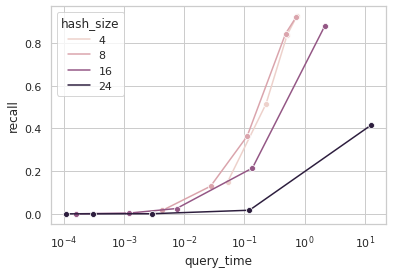

time: 1.54 s (started: 2021-05-27 12:25:25 +00:00)


In [ ]:
sns.set_theme(style='whitegrid')
ax = sns.lineplot(data=results, x='query_time', y='recall', hue='hash_size', legend='full', marker='o')
ax.set_xscale('log')

### LSH with multiple $g()$ (FAISS)

The previous index is equivalent to an LSH index with only one hash function $g()$. The `IndexBinaryMultiHash` provides the possibility of using multiple hashes (and thus multiple splits into buckets). This index uses the first `n_bits` for the first hash, the subsequent `n_bits` for the second hash, and so on until `n_hashes` hashes are formed.

In [ ]:
n_hashes = 8
n_bits = 4
index = faiss.IndexBinaryMultiHash(d_bits, n_hashes, n_bits)
index.add(xb)

time: 506 ms (started: 2021-05-27 12:25:26 +00:00)


At query time, we visit buckets having hashes that are at most `nflip` bits away from the hash of the query, for each hash group.

**NOTE**: at query time, we can change `nflip` without rebuilding the index; moreover, we can change the number of hashes `nhash` among the available ones that we want to use.

In [ ]:
index.nflip = 1
index.nhash = 4
D, I = index.search(qb, k)

time: 20.9 s (started: 2021-05-27 12:25:27 +00:00)


In [ ]:
compute_recall(true_neighbors, I)

0.9004000000000001

time: 10.1 ms (started: 2021-05-27 12:25:48 +00:00)


An example for searching operational points:

In [ ]:
n_hashes = (2, 4, 8, 16)
n_bits = (8, 16)
n_flips = (0, 1, 2)

results = []

for nb in tqdm(n_bits):  # try a bunch of n_bits for the hash size

  # we build only the index with the maximum n_hashes and use index.nhash to use less hashes at query time
  index = faiss.IndexBinaryMultiHash(d_bits, max(n_hashes), nb) 
  index.add(xb)

  for nh in tqdm(n_hashes, leave=False):  # try a bunch of n_hashes
    for nh, nf in tqdm(n_flips, leave=False):  # try a bunch of n_flips
      if nf > nb: continue
      print(f'nb={nb} nh={nh} nf={nf}')

      index.nflip = nf
      index.nhash = nh

      start = time.time()
      D, I = index.search(qb, k)
      elapsed = time.time() - start

      results.append({
          'hash_size': nb,
          'nhashes': nh,
          'nflips': nf,
          'recall': compute_recall(true_neighbors, I),
          'query_time': elapsed
      })

results = pd.DataFrame(results)
results

nb=8 nh=2 nf=0
nb=8 nh=2 nf=1
nb=8 nh=2 nf=2
nb=8 nh=4 nf=0
nb=8 nh=4 nf=1
nb=8 nh=4 nf=2
nb=8 nh=8 nf=0
nb=8 nh=8 nf=1
nb=8 nh=8 nf=2
nb=8 nh=16 nf=0
nb=8 nh=16 nf=1
nb=8 nh=16 nf=2


nb=16 nh=2 nf=0
nb=16 nh=2 nf=1
nb=16 nh=2 nf=2
nb=16 nh=4 nf=0
nb=16 nh=4 nf=1
nb=16 nh=4 nf=2
nb=16 nh=8 nf=0
nb=16 nh=8 nf=1
nb=16 nh=8 nf=2
nb=16 nh=16 nf=0
nb=16 nh=16 nf=1
nb=16 nh=16 nf=2



,hash_size,nhashes,nflips,recall,query_time
0,8,2,0,0.0362,0.115108
1,8,2,1,0.2378,1.209324
2,8,2,2,0.5906,6.434509
3,8,4,0,0.0796,0.220396
4,8,4,1,0.4268,2.726984
5,8,4,2,0.8344,16.917049
6,8,8,0,0.1592,0.566000
7,8,8,1,0.6804,7.028177
8,8,8,2,0.9184,23.813848
9,8,16,0,0.2934,1.101950


time: 2min 5s (started: 2021-05-27 12:25:48 +00:00)


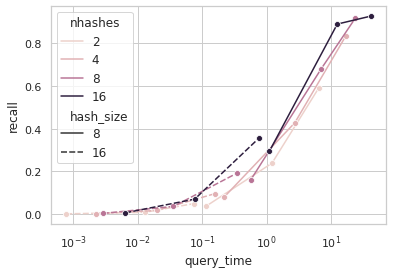

time: 1.29 s (started: 2021-05-27 12:27:54 +00:00)


In [ ]:
sns.set_theme(style='whitegrid')
ax = sns.lineplot(data=results, x='query_time', y='recall', hue='nhashes', style='hash_size', legend='full', marker='o')
ax.set_xscale('log')

**WARNING**: FAISS provides also an `IndexLSH` class, but this class is intended for _producing hashes from real-valued vectors that are then compared with the Hamming distance, without any kind on bucketing_.
We will see this index in the following Open Lab when tackling real-valued vectors.

## Indexing Metric Objects ($o \in$ Strings, $d =$ Edit Distance)

Now, we will explore a scenario in which objects aren't real-valued vectors, and common tools for euclidean spaces cannot be applied, and solutions for generic metric spaces must be applied.

### Getting Started

As objects to be indexes, we will consider a set of strings that we want to compare with the Levenshtein distance (a.k.a. edit distance).
We install the `python-Levenshtein` package that provides an efficient implementation of the edit distance.

In [ ]:
!pip install -q python-Levenshtein

     |████████████████████████████████| 51kB 5.7MB/s 


In [ ]:
from Levenshtein import distance as edit_distance
from scipy.spatial.distance import cdist

As database objects, we select a dataset of english given names available in the Natural Language Toolkit (nltk).

In [ ]:
import nltk
nltk.download('names')
from nltk.corpus import names

db = names.words()  
db = list(set(db))  # remove duplicates
db = np.array(db, dtype=np.object)  # database
queries = np.random.choice(db, 10)  # queries

db, len(db)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


(array(['Dannye', 'Bartie', 'Clea', ..., 'Cristy', 'Daffi', 'Andrei'],
       dtype=object), 7579)

In [ ]:
db[0], queries[0], edit_distance(db[0], queries[0])

('Dannye', 'Marcellina', 9)

Let's define a helper function to compute the edit distance between two sets of strings (similar to the [`scipy.spatial.distance.cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) function for real-valued vectors).

In [ ]:
def edit_cdist(a, b):
  D = np.empty((len(a), len(b)), dtype=np.int32)

  for i, qi in enumerate(a):
    for j, xj in enumerate(b):
      D[i, j] = edit_distance(qi, xj)

  return D

### Sequential Scan / Bruteforce

As baseline, we compute the whole distance matrix between queries and datasets to get the true neighbors.

**NOTE**: this operation is usually unfeasible for datasets large enough to need indexing.

In [ ]:
D = edit_cdist(queries, db)
D

array([[9, 7, 8, ..., 9, 8, 8],
       [5, 4, 5, ..., 5, 5, 5],
       [6, 5, 6, ..., 7, 7, 7],
       ...,
       [6, 5, 6, ..., 7, 6, 6],
       [5, 4, 5, ..., 6, 5, 6],
       [8, 7, 8, ..., 6, 8, 8]], dtype=int32)

time: 47.4 ms (started: 2021-06-01 14:01:12 +00:00)


In [ ]:
true_neighbors = D.argsort(axis=1)
queries[7], db[true_neighbors[7, :5]]

('Gearard',
 array(['Gearard', 'Gerrard', 'Gerard', 'Gerald', 'Bearnard'], dtype=object))

time: 12.3 ms (started: 2021-06-01 14:01:46 +00:00)


### Permutation-based Indexing

We will see a permutation-based technique, specifically the Metric Inverted File, to index metric objects.
In permutation-based indexing, we transform our dataset using distances to a set of reference points (a.k.a. pivots).
For each data point, we use the ordered sequence of the pivots, from the nearest to the farthest, as representation. This ordered sequence is also called **permutataion**.

Similar objects will have similar permutations, specially in the first part of the permutation.

Permutations can be compared using the **Spearman's Footrule Distance (SFD)** that sums the difference in position for each pivot.

Let's start by randomly choosing a set of pivots.

In [ ]:
pivots = np.random.choice(db, 25)
pivots

array(['Solomon', 'Amalita', 'Hattie', 'Willyt', 'Alwin', 'Stafani',
       'Gussy', 'Oren', 'Cordula', 'Alaa', 'Lena', 'Corrie', 'Maure',
       'Lusa', 'Horatius', 'Tyne', 'Thaxter', 'Johnnie', 'Marissa', 'Tim',
       'Vikky', 'Cate', 'Phaidra', 'Augustin', 'Antony'], dtype=object)

time: 8.29 ms (started: 2021-06-01 14:03:51 +00:00)


Next, we compute the distances of each dataset object to the pivots ...

In [ ]:
xp_distances = edit_cdist(db, pivots)
xp_distances.shape
xp_distances[0]

array([7, 6, 4, 5, 6, 6, 5, 5, 7, 6, 5, 5, 4, 6, 7, 4, 6, 4, 6, 6, 5, 4,
       6, 8, 5], dtype=int32)

time: 88 ms (started: 2021-06-01 14:05:35 +00:00)


.. and sort the distances to find how pivots are ranked.

In [ ]:
# permutation: i -> pivot with rank i
xp_permutation = xp_distances.argsort(axis=1)
xp_permutation

array([[12, 21,  2, ...,  8,  0, 23],
       [ 2, 21, 11, ...,  1, 13,  0],
       [ 9, 13, 21, ..., 14, 17, 23],
       ...,
       [21, 20,  6, ...,  5, 14,  0],
       [12,  2, 21, ..., 23,  8,  0],
       [12,  7, 24, ..., 18, 14,  0]])

time: 13.2 ms (started: 2021-06-01 14:06:08 +00:00)


For computing the SFD, we need to find the position of each pivot, ordered by pivot number (also called **inverse permutation**).
This can be found by sorting again the permutation:

In [ ]:
# inverse permutation: i -> position of pivot i
xp_inv_perm = xp_permutation.argsort(axis=1)
xp_inv_perm

array([[23, 19,  2, ..., 20, 24,  8],
       [24, 22,  0, ..., 12, 15, 14],
       [17, 13, 20, ..., 15, 24, 21],
       ...,
       [24, 20, 19, ..., 11, 15,  4],
       [24, 19,  1, ..., 14, 22, 17],
       [24, 19, 15, ...,  9, 16,  2]])

time: 11 ms (started: 2021-06-01 14:10:34 +00:00)


Let's find also the representations of the queries by applying the same steps:

In [ ]:
qp_distances = edit_cdist(queries, pivots)
qp_inv_perm = qp_distances.argsort(axis=1).argsort(axis=1)
qp_inv_perm.shape

(10, 25)

time: 6.66 ms (started: 2021-06-01 14:11:01 +00:00)


Finally, we can compute the SFD between queries and datasets representations; this is equivalent to the L1 distances between the inverted permutations.

In [ ]:
qx_sfd = cdist(qp_inv_perm, xp_inv_perm, metric='cityblock')
qx_sfd.shape

(10, 7579)

time: 13.9 ms (started: 2021-06-01 14:11:42 +00:00)


Let's use the SFD to rank objects by similar permutations, and check that still we are retrieving similar object first.

In [ ]:
I = qx_sfd.argsort(axis=1)

queries[8], db[I[8,:5]], db[true_neighbors[8,:5]]

('Jillie',
 array(['Jillie', 'Billie', 'Willie', 'Tillie', 'Welbie'], dtype=object),
 array(['Jillie', 'Willie', 'Gillie', 'Tillie', 'Jilli'], dtype=object))

time: 20.9 ms (started: 2021-06-01 14:14:21 +00:00)


In [ ]:
k = 10
compute_recall(true_neighbors[:, :k], I[:, :k])

0.31

time: 109 ms (started: 2021-06-01 14:16:32 +00:00)


### Metric Inverted File (MI-File)

Up to now, we transformed metric objects to permutations that can be compared with the SFD, but we gained no advantage in the query time and we lost in recall.

The real advantage of using permutations as representations is the possibility of efficiently indexing them using permutation-based indices.

Here, we will implement a simple RAM-based Metric Inverted File that will support the following parameters:


*   **`n_pivots`**: the number of posting lists (one per pivot); each posting list will contain entries with an object ID $o$ and the position of the pivot in $o$'s permutation.
*   **`k_x`**: the length of the prefix of the permutation that we insert in the posting lists (the values of the permutation after the `k_x`-th will be discarded); _this controls the length of the posting lists_.
*   **`k_s`**: the length of the prefix of the permutation of the query that we use for search (the posting lists of the pivots that are in position > `k_s` will be accessed); _this controls the number of posting lists accessed per query_.
*   **`mdp`**: the maximum distance of the position; we will access entries of a posting lists having the pivot's positions at most `mdp` away from the one of the query; _this controls the number of entries in posting list that are accessed_.



In [ ]:
!pip install -q sortedcontainers

time: 2.64 s (started: 2021-06-01 14:40:04 +00:00)


In [ ]:
from collections import defaultdict
from sortedcontainers import SortedList

time: 12.8 ms (started: 2021-06-01 14:40:07 +00:00)


In [ ]:
class MIFile():
  """ This class implements a Metric Inverted Files for indexing and searching
      permutations.
  """

  def __init__(self, n_pivots, k_x=None):
    """ Constructs a new index with n_pivots posting lists, initially empty.

        - `k_x` is the length of the prefix of permutation to index (pivots in
        positions > `k_x` will be discarded and not inserted in the index).
    """
    self.n_pivots = n_pivots
    self.posting_lists = defaultdict(SortedList)  # posting lists are sorted lists
    self.k_x = k_x or n_pivots

    self.ntotal = 0

  def add(self, x):
    """ Adds permutations to the indexes.

        - `x` is (n_samples x n_pivots) matrix containing n_samples permutations.
    """
    n_samples = len(x)
    new_ids = range(n_samples)  # ids are incremental integers

    for i, positions_of_pivot_i in enumerate(x.T):  # iterate over the pivots
      new_entries = zip(positions_of_pivot_i, new_ids)  # entries are tuples (pos, id)
      new_entries = filter(lambda e: e[0] < self.k_x, new_entries)  # keep only if pos < k_x
      self.posting_lists[i].update(new_entries)  # add entries to the pivot's posting list
    
    self.ntotal += n_samples
  
  def search(self, q, k=None, k_s=None, mdp=None):
    """ Searches the index for the `k` nearest neighbors of each query in `q`.

        - `q` is (n_queries x n_pivots) matrix containing n_queries permutations.
        - `k_s` is the length of the prefix of queries' permutation to use (pivots
        in positions > `k_s` will be discarded and the corresponding posting
        lists not accessed).
        - `mdp` is the maximum distance of pivot positions between query and 
        data point that is acceptable; entries in the posting lists with larger
        distances will not be accessed.
    """
    n_queries = len(q)
    k = k or self.ntotal
    k_s = k_s or self.n_pivots

    # prepare the output (-1 and infs means that less than k objects are retrieved)
    I = np.full((n_queries, k), fill_value=-1)
    D = np.full((n_queries, k), fill_value=np.inf)

    for i, qi in enumerate(q):  # process a query at the time
      distances = defaultdict(int)  # keeps partial SFD distance computations
      
      for j, q_pos in enumerate(qi):  # iterate the query inverse permutation
        if q_pos < k_s:  # consider pivot j only if is among the top k_s pivots
          posting_list = self.posting_lists[j]  # posting lists of pivot j

          # begin and end delimits the part of posting list to be accessed
          begin = (q_pos - mdp, 0) if mdp is not None else None
          end = (q_pos + mdp + 1, 0) if mdp is not None else None
          inclusive = (True, False) if mdp is not None else (True, True)

          for entry in posting_list.irange(begin, end, inclusive=inclusive):  # iterate over entries
            o_pos, o = entry
            distances[o] += abs(q_pos - o_pos)  # update the partial SFD of object o

      # distances now contain the SFD for each retrieved object o,
      # we sort results by increasing SFD
      qi_res = sorted(distances.items(), key=lambda x: x[1])
      ids, dists = zip(*qi_res)

      # we keep only the k object with smaller distances
      ids = np.array(ids)[:k]
      dists = np.array(dists)[:k]

      # we put results in I and D (note: results may be less than k)
      I[i, :len(ids)] = ids
      D[i, :len(dists)] = dists
    
    return D, I

  def n_entries(self):
    """ Returns the number of entries that comprise all the posting lists. """
    return sum(map(len, self.posting_lists.values()))

time: 67.8 ms (started: 2021-06-01 14:40:07 +00:00)


Now, we can use the MIFile as follows:

In [ ]:
n_pivots = len(pivots)
index = MIFile(n_pivots)

index.add(xp_inv_perm)
D, I = index.search(qp_inv_perm)
D, I

(array([[  0.,  60.,  76., ..., 268., 270., 270.],
        [  0.,  30.,  30., ..., 282., 284., 298.],
        [  0.,  52.,  58., ..., 278., 284., 286.],
        ...,
        [  0.,  70.,  76., ..., 276., 276., 276.],
        [  0.,  12.,  12., ..., 284., 284., 284.],
        [  0.,  68.,  76., ..., 278., 282., 284.]]),
 array([[3250,  139, 4193, ..., 3369, 2355,  370],
        [ 466,  499, 2084, ..., 5632,  753, 3264],
        [ 991, 1471, 6186, ..., 3264, 5094, 6971],
        ...,
        [3490,  128, 1482, ..., 2637, 3208, 1648],
        [  34, 1997, 4793, ..., 2201, 4993, 3191],
        [2022, 5688,  143, ..., 3204, 4625, 4735]]))

time: 1.56 s (started: 2021-06-01 14:40:07 +00:00)


In [ ]:
k = 10
compute_recall(true_neighbors[:, :k], I[:, :k])

0.31

time: 5.51 ms (started: 2021-06-01 14:40:09 +00:00)


In [ ]:
queries[3], db[I[3, :5]], db[true_neighbors[3, :5]]

('Floyd',
 array(['Floyd', 'Lloyd', 'Eliot', 'Willow', 'Wilow'], dtype=object),
 array(['Floyd', 'Lloyd', 'Ford', 'Flori', 'Flory'], dtype=object))

time: 4.75 ms (started: 2021-06-01 14:40:09 +00:00)


As for any index with parameters, we need to search the parameter space for good operational points:

In [ ]:
pivots = np.random.choice(db, 1000)  # pick 1000 pivots
k = 10  # k for recall

n_pivots = (10, 50, 100, 500, 1000)
k_xs = (10, 100, None)
k_ss = (10, 100, None)
mdps = (0, 10, 100, None)

results = []

for n_p in n_pivots:  # try a bunch of n_pivots
  p = pivots[:n_p]

  # compute permutations wrt pivots
  xp = edit_cdist(db, p).argsort(axis=1).argsort(axis=1)
  qp = edit_cdist(queries, p).argsort(axis=1).argsort(axis=1)

  for k_x in k_xs:  # try a bunch of k_x
    if k_x and k_x > n_p: continue

    # build the index
    index = MIFile(n_p, k_x=k_x)
    index.add(xp)

    for k_s in k_ss:  # try a bunch of k_s
      if k_s and k_s > n_p: continue

      for mdp in mdps:  # try a bunch of mdp
        if mdp is not None and mdp > n_p: continue

        print(f'np={n_p:4d} k_x={k_x} k_s={k_s} mdp={mdp}')

        # query the index
        start = time.time()
        _, Im = index.search(qp, k, k_s=k_s, mdp=mdp)
        elapsed = time.time() - start

        # save results
        results.append({
            'n_pivots': n_p,
            'k_x': k_x,
            'k_s': k_s,
            'mdp': mdp,
            'query_time': elapsed,
            'n_entries': index.n_entries(),
            'recall': compute_recall(I[:,:k], Im)
        })

results = pd.DataFrame(results)
results

np=  10 k_x=10 k_s=10 mdp=0
np=  10 k_x=10 k_s=10 mdp=10
np=  10 k_x=10 k_s=10 mdp=None
np=  10 k_x=10 k_s=None mdp=0
np=  10 k_x=10 k_s=None mdp=10
np=  10 k_x=10 k_s=None mdp=None
np=  10 k_x=None k_s=10 mdp=0
np=  10 k_x=None k_s=10 mdp=10
np=  10 k_x=None k_s=10 mdp=None
np=  10 k_x=None k_s=None mdp=0
np=  10 k_x=None k_s=None mdp=10
np=  10 k_x=None k_s=None mdp=None
np=  50 k_x=10 k_s=10 mdp=0
np=  50 k_x=10 k_s=10 mdp=10
np=  50 k_x=10 k_s=10 mdp=None
np=  50 k_x=10 k_s=None mdp=0
np=  50 k_x=10 k_s=None mdp=10
np=  50 k_x=10 k_s=None mdp=None
np=  50 k_x=None k_s=10 mdp=0
np=  50 k_x=None k_s=10 mdp=10
np=  50 k_x=None k_s=10 mdp=None
np=  50 k_x=None k_s=None mdp=0
np=  50 k_x=None k_s=None mdp=10
np=  50 k_x=None k_s=None mdp=None
np= 100 k_x=10 k_s=10 mdp=0
np= 100 k_x=10 k_s=10 mdp=10
np= 100 k_x=10 k_s=10 mdp=100
np= 100 k_x=10 k_s=10 mdp=None
np= 100 k_x=10 k_s=100 mdp=0
np= 100 k_x=10 k_s=100 mdp=10
np= 100 k_x=10 k_s=100 mdp=100
np= 100 k_x=10 k_s=100 mdp=None
np= 100 

,n_pivots,k_x,k_s,mdp,query_time,n_entries,recall
0,10,10.0,10.0,0.0,0.147433,75790,0.02
1,10,10.0,10.0,10.0,0.643034,75790,0.19
2,10,10.0,10.0,NaN,0.605172,75790,0.19
3,10,10.0,NaN,0.0,0.144209,75790,0.02
4,10,10.0,NaN,10.0,0.590208,75790,0.19
...,...,...,...,...,...,...,...
127,1000,NaN,100.0,NaN,5.462751,7579000,0.42
128,1000,NaN,NaN,0.0,0.385777,7579000,0.10
129,1000,NaN,NaN,10.0,3.276317,7579000,0.10
130,1000,NaN,NaN,100.0,17.117322,7579000,0.10


time: 4min 20s (started: 2021-06-01 14:40:14 +00:00)


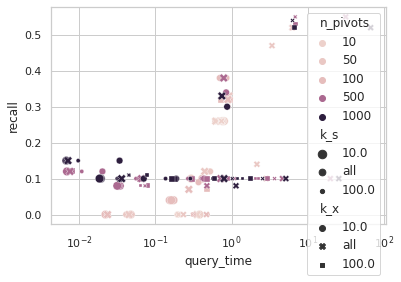

time: 1.37 s (started: 2021-05-27 12:34:14 +00:00)


In [ ]:
sns.set_theme(style='whitegrid')
data = results.fillna('all')
ax = sns.scatterplot(data=data, x='query_time', y='recall', hue='n_pivots', size='k_s', style='k_x')
ax.set_xscale('log')

In [ ]:
data = results.fillna('all')
good = (data.query_time < 1) & (data.recall > 0.3)
data[good]

,n_pivots,k_x,k_s,mdp,query_time,n_entries,recall
38,100,100,10,100,0.720718,757900,0.31
39,100,100,10,all,0.594543,757900,0.31
50,100,all,10,100,0.726694,757900,0.31
51,100,all,10,all,0.713664,757900,0.31
71,500,10,all,all,0.607843,75790,0.32
87,500,all,10,all,0.874647,3789500,0.36
107,1000,10,all,all,0.620608,75790,0.31
123,1000,all,10,all,0.609608,7579000,0.37


time: 42.6 ms (started: 2021-06-01 14:45:25 +00:00)


Let's find the operational point that has the best recall and a query time less than a second:

In [ ]:
good_op_idx = data[data.query_time < 1].recall.idxmax()
good_op = data.loc[good_op_idx]
good_op

n_pivots          1000
k_x                all
k_s                 10
mdp                all
query_time    0.609608
n_entries      7579000
recall            0.37
Name: 123, dtype: object

time: 15.3 ms (started: 2021-06-01 14:58:59 +00:00)


### Reordering using the original distance

A useful trick that is commonly used to boost the precision of an approximated index is **reordering**; if we are interested in `k` good neighbors, we can:

1.   use the fast approximated index to retrieve `k*amp` good candidate neighbors,
2.   compute the exact distance (the edit distance in our case) on the candidate set, 
3.   reorder the `k*amp` objects on the basis of the real distance and return the first k objects.

This usually boosts the recall at the cost of performing a small number of exact distance computations.

Let's try it out with our MIFile.

In [ ]:
n_pivots = 50
k_x = 10
k_s = None
mdp = None

p = pivots[:n_pivots]
xp = edit_cdist(db, p).argsort(axis=1).argsort(axis=1)
qp = edit_cdist(queries, p).argsort(axis=1).argsort(axis=1)

index = MIFile(n_pivots, k_x=k_x)
index.add(xp)

time: 2.4 s (started: 2021-06-01 15:02:52 +00:00)


In [ ]:
k = 10
amp = 100
D, I = index.search(qp, k=k*amp, k_s=k_s, mdp=mdp)

compute_recall(true_neighbors[:,:k], I[:,:k])  # approximated search has low recall

0.27

time: 721 ms (started: 2021-06-01 15:03:28 +00:00)


In [ ]:
reranked_results = []

for i in range(len(queries)):  # iterate over queries
  query_i = queries[i:i+1]  # the i-th query (string)
  results_indices_i = I[i]  # the i-th approximated results set (indices)
  results_i = db[results_indices_i]  # the i-th candidate set (strings)

  real_distances = edit_cdist(query_i, results_i)  # compute the real edit distance between strings
  reranked = real_distances.argsort(axis=1)  # sort by the real distance
  reranked_results_i = results_indices_i[reranked]  # we rerank the indices
  reranked_results.append(reranked_results_i)

I = np.stack(reranked_results)

compute_recall(true_neighbors[:,:k], I[:,:k])

0.9100000000000001

time: 20.5 ms (started: 2021-06-01 15:05:03 +00:00)


## Additional Resources

*   https://ai.facebook.com/tools/faiss/
*   https://github.com/facebookresearch/faiss/wiki/
*   http://mifile.deepfeatures.org/
